In [1]:
import arviz as az
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import seaborn as sns

from cli  import transform_fn_mapping, transform_fn_mapping_inv, fit_model
from copy import deepcopy
from functools import partial, reduce
from itertools import product
from sklearn.gaussian_process.kernels import Matern
from string import ascii_lowercase
from tqdm   import tqdm, trange

plt.style.reload_library()
plt.style.use('science')

Matern52 = partial(Matern, nu=2.5)

def merge_first_two_dims(x):
    first_dims = x.shape[0] * x.shape[1]
    return x.reshape(first_dims, *x.shape[2:])

def outer_nd(vectors):
    '''
    Generalizes np.outer to more than 2 vectors
    '''
    out = 1.
    for i, vec in enumerate(vectors):
        
        # Keep adding extra dims onto vectors
        for j in range(i):
            vec = vec[:,None]
        out = out * vec
        
    return out
    
def mv_einstein(matrices, y):
    '''
    Use Einstein summation convention to iteratively
    contract along secondary axes and implement Kronecker 
    matrix-vector product
    '''
    p = len(matrices)
    
    if p > 13:
        raise ValueError('There aren\'t enough letters in the alphabet for this operation :(')
    
    letter_pairs = [ascii_lowercase[2*i]+ascii_lowercase[2*i+1] for i in range(p)]
    matrix_string = ','.join(letter_pairs)
    vec_in_string, vec_out_string = [''.join(s) for s in zip(*letter_pairs)]
    string_spec = f'{matrix_string},{vec_in_string}->{vec_out_string}'
    
    return np.einsum(string_spec, *matrices, y, optimize='greedy'), string_spec

def _parse_inputs(data, domains, input_scales, input_offsets):
    '''
    Helper function to extract arrays of input coordinates
    for GP modeling.
    '''
    Xms = []
    Xns = []

    if 'space' in domains:
        Xms += [data['space']]
        Xns += [data['space']]
    if 'time' in domains:
        Xms += [data['time'][:, None]]
        Xns += [data['time'][:, None]]    
    if 'process' in domains:
        Xms += [data['process'][data['test_indices']]]
        Xns += [data['process'][data['train_indices']]]
        
    def _standardize(Xs):
        return [X/scale+offset for X, scale, offset in zip(Xs, input_scales, input_offsets)]
        
    Xms = _standardize(Xms)
    Xns = _standardize(Xns)
    
    return Xms, Xns

def predict_cov_diag(Kms, Kns, Kmns, nugget_var):
    '''
    Calculates diagonal elements of predictive covariance matrix
    for new locations, given Kronecker factors.
    '''
    n_domains = len(Kms)
    root_var = nugget_var ** (1./n_domains)
    marginal_cov = [np.prod(tup) for tup in product(*[np.diag(Km) for Km in Kms])]
    cond_cov = [np.prod(tup) for tup in product(*[np.diag(Kmn @ np.linalg.inv(Kn + np.eye(len(Kn))*root_var) @ Kmn.T) for Kmn, Kn in zip(Kmns, Kns)])]
    return nugget_var + np.asarray(marginal_cov) - np.asarray(cond_cov)

def eval_kernels(Xms, Xns, ls, gpvar, nugget_var):
    Kms  = []
    Kmns = []
    Kns  = []
    
    ls     = np.atleast_1d(ls)
    
    n_domains = len(Xms)

    for i in range(n_domains):
        if i == 0:
            var = gpvar
        else:
            var = 1
        kernel_fn = Matern52(length_scale=ls[i])

        Kms  += [kernel_fn(Xms[i], Xms[i])*var]
        Kmns += [kernel_fn(Xms[i], Xns[i])*var]
        Kns  += [kernel_fn(Xns[i], Xns[i])*var]
    return Kms, Kmns, Kns

def predict_mean(Kns, Knms, y, nugget_var, mean, scale, offset, response_map_inv):
    '''
    Generates vector of predictive means.
    '''
    eigen = [scipy.linalg.eigh(K) for K in Kns]
    eigval, eigbasis = zip(*eigen)

    eigbasis_inv = [scipy.linalg.inv(Q).T for Q in eigbasis]
    eigbasis = [Q.T for Q in eigbasis]

    eigval_array      = outer_nd(eigval)
    eigval_array     += nugget_var 
    eigval_array_inv  = 1./ eigval_array

    mu_std, _ =  mv_einstein(eigbasis_inv, y)
    mu_std    =  eigval_array_inv.T * mu_std
    mu_std, _ =  mv_einstein(eigbasis, mu_std)
    mu_std, _ =  mv_einstein(Knms, mu_std)
    
    return response_map_inv((mu_std + mean) * scale + offset), mu_std

def make_scatter_plots(y_test, mu_new, alg, spec, response_scale, Knew, sigma, figsize=(10,4), ax=None,
                      fig_kwargs={'figsize':(4,4)},
                      err_kwargs={'ls':'none','color':'0.5','alpha':0.35,'capsize':6},
                      scatter_kwargs={'color':'k','s':10},
                      hexbin_kwargs={'bins':'log', 'cmap':'cividis','gridsize':50},
                      show_err_bar=True, use_hexbin=False):
    '''
    Makes plots showing side-by-side comparisons of predictive accuracy in the 
    original response space versus the transformed space
    '''
    if not ax:
        fig = plt.figure(**fig_kwargs)
        ax = plt.gca()    
    else:
        fig = plt.gcf()
        plt.sca(ax)
    if use_hexbin:
        hb = ax.hexbin(y_test, mu_new,
               **hexbin_kwargs)
        plt.colorbar(hb,fraction=0.046, pad=0.04)
    else:
        ax.scatter(y_test, mu_new,
                   **scatter_kwargs)      
    
    mae = np.mean(np.abs(y_test-mu_new))
    ax.text(0.06, 0.92,f'MAE: {mae:.2f}',
         horizontalalignment='left',
         verticalalignment='center',
         transform = ax.transAxes, fontsize=12, fontweight='bold')
    pred_sigma = response_scale*(Knew) ** 0.5
    lower, upper =  mu_new-pred_sigma,  mu_new+pred_sigma,
    err_sigma = sigma * response_scale
    if show_err_bar:
        ax.errorbar(y_test, lower, upper, **err_kwargs)
    ax.set_ylabel('Predicted'), ax.set_xlabel('True')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
  
    ax.plot(lims, lims, 'k-', alpha=0.5, zorder=3)
    err_sigma = sigma * response_scale

    ax.fill_between(lims, lims-2*err_sigma, lims+2*err_sigma, color='m', alpha=0.25)
    is_in_bounds = np.logical_and(y_test > mu_new-2*err_sigma, y_test < mu_new+2*err_sigma )
    coverage = np.mean(is_in_bounds)
    ax.text(0.06, 0.84,f'Coverage: {int(100*coverage)}\%',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes, fontsize=12, fontweight='bold')
    
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return fig, ax

def load_trace(json_path, thin_factor=1):
    try:
        with open(json_path, 'r') as infile:
            trace = json.loads(infile.read())
            return trace['posterior']
    except:
        print(f'Loading failed for {json_path}')
        
def thin_along_2nd_axis(dictionary, thin_factor):
    for k,v in dictionary.items():
        if v.ndim > 1:
            dictionary[k] = v[:, ::thin_factor]
    return dictionary

def fix_shapes(x):
    x = np.asarray(x)
    
    if x.ndim == 2:
        new =  x.reshape(x.shape[0]*x.shape[1])
    elif x.ndim == 3:
        new =  x.reshape(x.shape[0]*x.shape[1], x.shape[2])
    else:
        new = x
    return new.squeeze()

def vary_ndims(array, varying_dims, resolution=10):
    '''
    Create new ndarray holding some columns constant
    and equal to the column medians while letting
    others vary in a linear interpolation.
    '''
    _, ncols = array.shape
    mins, medians, maxes = array.min(axis=0), np.median(array,axis=0), array.max(axis=0)
    coord_vectors = [list(np.linspace(mins[d], maxes[d], resolution)) if d in varying_dims else [medians[d]] for d in range(ncols)]
    new_points = np.asarray(list(product(*coord_vectors)))
    return new_points

alg_colors = {
    'map' :'g',
    'mcmc':'c',
    'vi'  :'m'
}

In [2]:
EXTRA_DIMS_PER_ALG = {
            'map' : (0,1,),
            'mcmc': (0,1,),
            'vi'  : (0,1,)
        }

PYMC3_VARNAMES = [
            'mean', 'ls', 'gp_variance', 'sigma'
        ]

FANCY_NAMES = {
    'space+time+process'    : 'Space/time/process coordinates',
    'time+process'          : 'Time/process coordinates',
    'process'               : 'Process coordinates',
    'vi'    : 'VI',
    'mcmc'  : 'MCMC',
    'map'   : 'MAP gradient ascent',
    'sir'     : 'SIR model',
    'couzin'  : 'Couzin model',
    'kauffman': 'Kauffman network'
}

models   = ['process', 'time+process', 'space+time+process']
algs     = ['map', 'mcmc','vi', ]
DATASETS = ['sir', 'couzin', 'kauffman']

data_dir = '../data/processed-emulator-inputs/'

# Maps models to the coordinate sets used
# for posterior predictive estimation


### Loading independent GP comparisons

In [3]:
save_path = '../outputs/independentgp/test_predictions.json'

with open(save_path, 'r') as src:
    text = src.read()
    independent_predictions = json.loads(text)

### Plots of posterior distributions in parameter space

In [4]:
posteriors = {}

for dataset in DATASETS:
    data_filepath   = f'{data_dir}{dataset}.json'
    for spec_idx, spec in enumerate(models):
        for alg_idx, alg in enumerate(algs):
            token = f'{dataset}_{spec}_{alg}'
            json_path     = f'../outputs/{token}.json' 
            domains           = spec.split('+')
            response_key      = spec + '_response'
            print(f'Loading {json_path}')

            try:
                with open(json_path, 'r') as infile:
                    trace = json.loads(infile.read())
                    posteriors[token] = deepcopy(trace['posterior'])

            except FileNotFoundError:
                print(f'File {json_path} not found.')
                continue

Loading ../outputs/sir_process_map.json
Loading ../outputs/sir_process_mcmc.json
Loading ../outputs/sir_process_vi.json
Loading ../outputs/sir_time+process_map.json
Loading ../outputs/sir_time+process_mcmc.json
Loading ../outputs/sir_time+process_vi.json
Loading ../outputs/sir_space+time+process_map.json
Loading ../outputs/sir_space+time+process_mcmc.json
Loading ../outputs/sir_space+time+process_vi.json
Loading ../outputs/couzin_process_map.json
Loading ../outputs/couzin_process_mcmc.json
Loading ../outputs/couzin_process_vi.json
Loading ../outputs/couzin_time+process_map.json
Loading ../outputs/couzin_time+process_mcmc.json
Loading ../outputs/couzin_time+process_vi.json
Loading ../outputs/couzin_space+time+process_map.json
Loading ../outputs/couzin_space+time+process_mcmc.json
Loading ../outputs/couzin_space+time+process_vi.json
Loading ../outputs/kauffman_process_map.json
Loading ../outputs/kauffman_process_mcmc.json
Loading ../outputs/kauffman_process_vi.json
Loading ../outputs/kau

In [5]:
latex_names = {
    'mean' :'$\\mu$', 
    'alpha':'$\\alpha$', 
    'sigma':'$\\sigma$',
    'ls_space':'$\\ell_{space}$',
    'ls_time':'$\\ell_{time}$',
    'ls_process':'$\\ell_{process}$'
}

In [6]:
linestyles={
    'vi':'solid',
    'mcmc':'solid',
    'map':'solid'
}

 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_27232/1385326259.py:25: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_27232/1385326259.py:25: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 /var/folders/6r/w3lbv3gd1b972rxy70nv22mrv3hfdg/T/ipykernel_27232/1385326259.py:25: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

Skipping kauffman_space+time+process_map
Skipping kauffman_space+time+process_mcmc
Skipping kauffman_space+time+process_vi


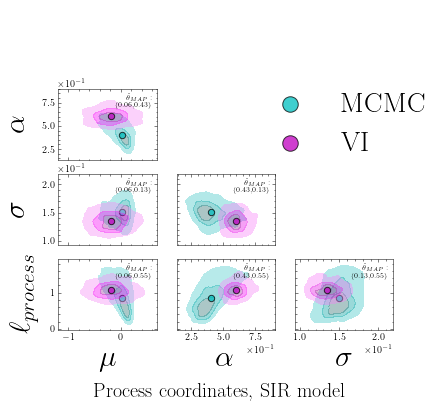

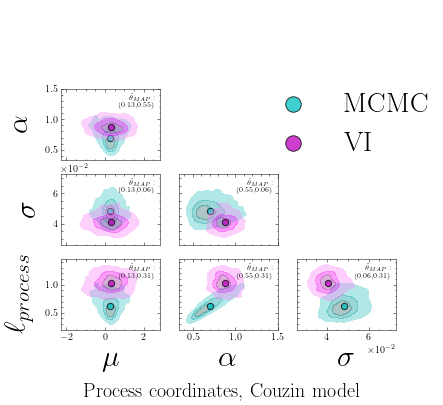

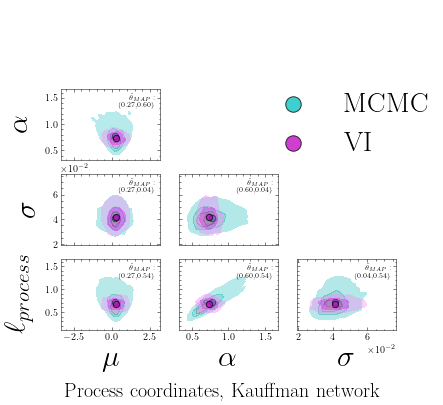

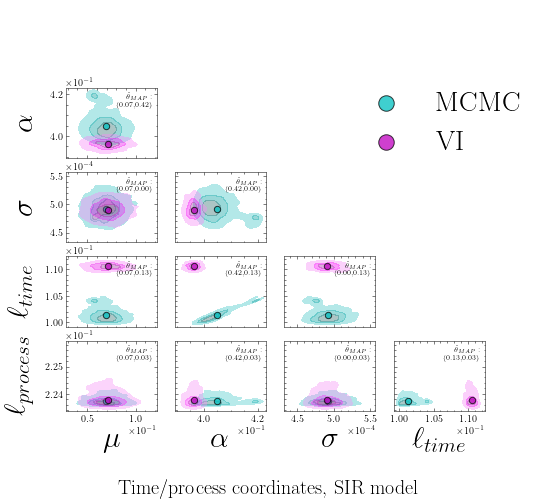

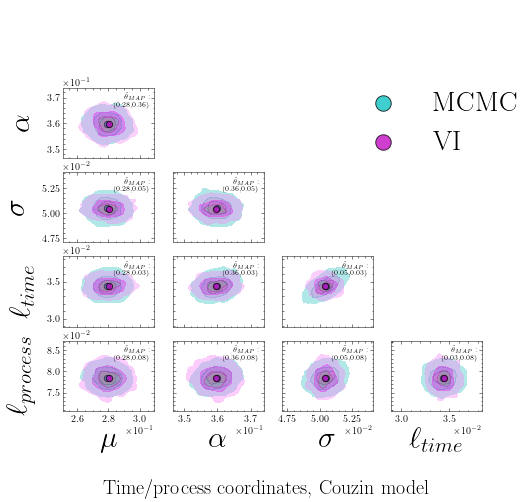

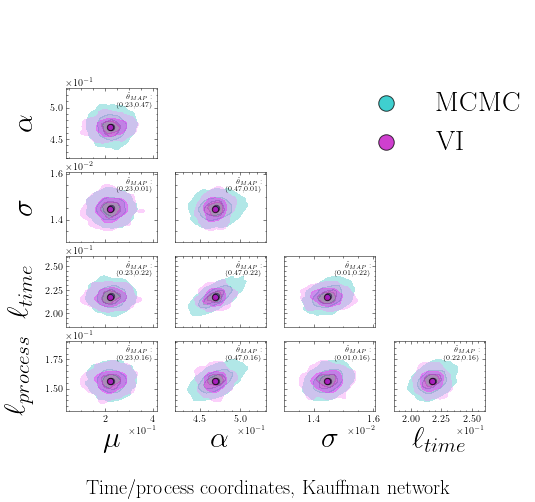

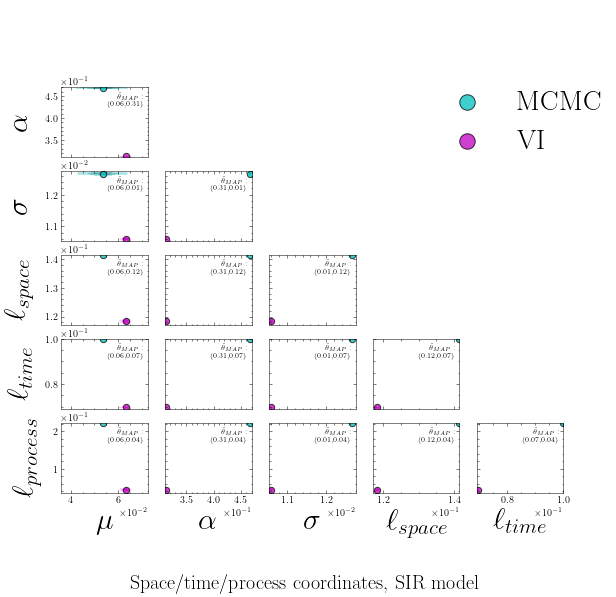

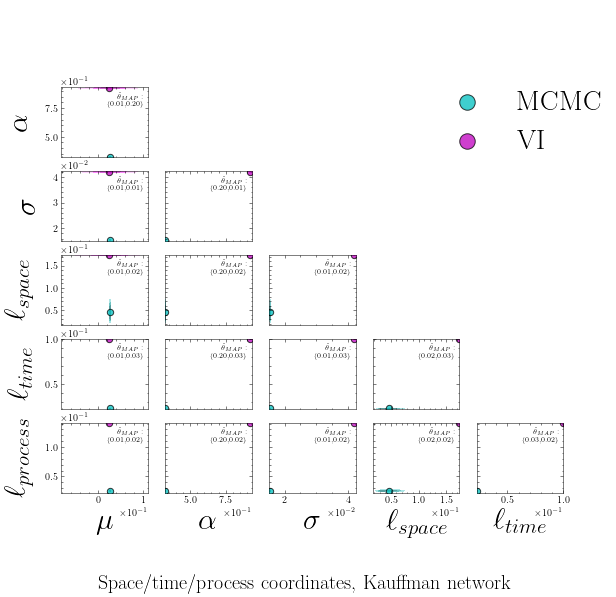

In [7]:
ctr = 0
bbox_props = dict(boxstyle='round', facecolor='wheat', alpha=0.45)
kde_kwargs = {}
show_line  = False
levels     = 4
label_size = 30

show_pt_only = ['map']

limit_inflation_factor = 0.5

all_traces = {}

for spec in ['process', 'time+process', 'space+time+process']:
    for dataset in DATASETS:
        make_new = True
        handles  = []
        for alg in algs:
            key = f'{dataset}_{spec}_{alg}'

            #if ('map' in key) or (not key in posteriors.keys()):
            if (not key in posteriors.keys()):
                print(f'Skipping {key}')
                continue

            trace = {k: np.asarray(v) for k,v in posteriors[key].items()}

            if 'space' in spec:
                trace['ls_space']= trace['ls'][...,-3]
            if 'time' in spec:
                trace['ls_time'] = trace['ls'][...,-2]            
            if 'process' in spec:
                trace['ls_process'] = trace['ls'][...,-1]
            if 'gp_scale' in trace.keys():
                trace['alpha'] = np.asarray(trace['gp_scale']) ** 0.5

            #figure_filepath = f'./figures/posterior_pairwise/{key[0]}_{key[1]}.png'
            plotting_vars    = [x for x in latex_names.keys() if x in trace.keys()]  
            plotting_samples = {x: np.asarray(trace[x]).squeeze().ravel() for x in plotting_vars if x in trace.keys()} 
            sample_df        = pd.DataFrame(plotting_samples)
            
            all_traces[key] = sample_df

            P = len(plotting_vars)
            fig_size_inches = P*1.5

            if make_new:
                fig, axes = plt.subplots(P,P-1, figsize=(fig_size_inches,fig_size_inches),
                                         sharex='col', sharey='row')
                make_new = False

            nticks=6

            var_lims  = {x: (plotting_samples[x].min(), plotting_samples[x].max()) for x in plotting_vars}
            quantiles = [2.5, 97.5]
            is_first  = True
            for i in range(P):
                for j in range(P):
                    if i != j and j>i:

                        plt.sca(axes[j,i])
                        x = plotting_samples[plotting_vars[i]]
                        y = plotting_samples[plotting_vars[j]]

                        '''
                        corr = np.corrcoef(x,y)[1,0]
                        axes[j,i].text(0.075,0.1,f'r={corr:.2f}', fontsize=10,transform=axes[j,i].transAxes,
                                      fontweight='bold', bbox=bbox_props)
                        '''
                        if alg in show_pt_only: 
                            plt.text(0.95, 0.93,
                                     '$\\hat{\\theta}_{MAP}:$' + f'\n({x[0]:.2f},{y[0]:.2f})',
                                     transform = axes[j,i].transAxes, ha='right',
                                     va='top',
                                    fontsize=7)
                        else:
                            sns.kdeplot(x,y=y, color=alg_colors[alg],
                                        ax=axes[j,i],
                                        linestyles=linestyles[alg],
                                        levels=4, shade=True, alpha=0.4,
                                        warn_singular=False)

                            ylow, yhi = var_lims[plotting_vars[j]]
                            yticks = np.linspace(ylow, yhi, nticks)

                            xlow, xhi = var_lims[plotting_vars[i]]
                            xticks = np.linspace(xlow, xhi, nticks)
                            xmean, ymean = x.mean(), y.mean()

                            handle = axes[j,i].scatter(xmean, ymean,
                                        color=alg_colors[alg],
                                        edgecolor='k', s=40, alpha=0.75,
                                        )

                            if is_first:
                                handles += [handle]
                                is_first = False

                            if show_line:
                                x_qs = np.percentile(x, quantiles)

                                plt.plot(x_qs,[ymean,ymean], color='k', marker='|')

                                y_qs = np.percentile(y, quantiles)
                                plt.plot([xmean,xmean], y_qs, color='k', marker='_')
                                [plt.axvline(x, color='k', linestyle='--', alpha=0.2) for x in x_qs]
                                [plt.axhline(y, color='k', linestyle='--', alpha=0.2) for y in y_qs]

                            if i == 0:
                                plt.ylabel(latex_names[plotting_vars[j]], fontsize=label_size,labelpad=12)

                            plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
                            
                            '''# Inflate the x and y limits so that points are not cutoff
                            old_xlim = plt.xlim()
                            plt.xlim([old_xlim[0]*limit_inflation_factor,
                                      old_xlim[1] + old_xlim[1]*limit_inflation_factor])
                            
                            old_ylim = plt.ylim()
                            plt.ylim([old_ylim[0]*limit_inflation_factor,
                                      old_ylim[1] + old_ylim[1]*limit_inflation_factor])'''
                    else:
                        try:
                            axes[j,i].axis('off')
                        except IndexError:
                            pass

            for j in range(P-1):            
                axes[-1,j].set_xlabel(latex_names[plotting_vars[j]], fontsize=label_size, labelpad=3)
            if alg not in show_pt_only:
                plt.sca(axes[1, -1])
                plt.scatter([], [],
                                color=alg_colors[alg],
                                edgecolor='k', s=240, alpha=0.75,
                                label=FANCY_NAMES[alg])
        plt.sca(axes[1, -1])
        plt.legend(loc='center', fontsize=28)

        # Pick off only the first and last handles to get 
        # the two algorithms covered
        '''plt.figlegend(handles, labels=['MCMC', 'VI'],
                   loc='lower center',
                   ncol=len(handles))'''

        plt.suptitle(FANCY_NAMES[spec] + ", " + FANCY_NAMES[dataset],
                     y=-0.0, x=0.5, ha='center',
                    fontsize=20)

        figure_filepath = f'../figures/{dataset}_{spec}_posteriors.png'
        plt.savefig(figure_filepath, dpi=400, bbox_inches='tight')

### Making table of posterior estimates

In [22]:
for dataset in DATASETS:
    data_filepath   = f'{data_dir}{dataset}.json'
    for spec_idx, spec in enumerate(models):
        for alg_idx, alg in enumerate(algs):
            token = f'{dataset}_{spec}_{alg}'
            json_path     = f'../outputs/{dataset}_{spec}_{alg}.json' 
            try:
                with open(json_path, 'r') as infile:
                    trace = json.loads(infile.read())
                    posterior = deepcopy(trace['posterior'])

            except FileNotFoundError:
                print(f'File {json_path} not found.')
                continue

            auxiliary = {k:v for k,v in posterior.items() if k not in PYMC3_VARNAMES}
            response_scale   = auxiliary['response_scale']
            response_offset  = auxiliary['response_offset']
            print(token, f"{response_scale:.1f}", f"{response_offset:.2f}")

sir_process_map 79.0 0.00
sir_process_mcmc 79.0 0.00
sir_process_vi 79.0 0.00
sir_time+process_map 9942.0 0.00
sir_time+process_mcmc 9946.0 0.00
sir_time+process_vi 9856.0 0.00
sir_space+time+process_map 261.0 0.00
sir_space+time+process_mcmc 252.0 0.00
sir_space+time+process_vi 261.0 0.00
couzin_process_map 0.0 0.00
couzin_process_mcmc 0.3 0.03
couzin_process_vi 0.0 0.01
couzin_time+process_map 0.9 0.01
couzin_time+process_mcmc 0.9 0.01
couzin_time+process_vi 0.9 0.01
couzin_space+time+process_map 0.9 0.00
couzin_space+time+process_mcmc 1.0 0.00
couzin_space+time+process_vi 1.0 -0.00
kauffman_process_map 0.4 0.00
kauffman_process_mcmc 0.4 0.00
kauffman_process_vi 0.4 0.00
kauffman_time+process_map 0.5 0.00
kauffman_time+process_mcmc 0.5 0.00
kauffman_time+process_vi 0.5 0.00
File ../outputs/kauffman_space+time+process_map.json not found.
File ../outputs/kauffman_space+time+process_mcmc.json not found.
File ../outputs/kauffman_space+time+process_vi.json not found.


In [127]:
all_traces.keys()

dict_keys(['sir_process_map', 'sir_process_mcmc', 'sir_process_vi', 'couzin_process_map', 'couzin_process_mcmc', 'couzin_process_vi', 'kauffman_process_map', 'kauffman_process_mcmc', 'kauffman_process_vi', 'sir_time+process_map', 'sir_time+process_mcmc', 'sir_time+process_vi', 'couzin_time+process_map', 'couzin_time+process_mcmc', 'couzin_time+process_vi', 'kauffman_time+process_map', 'kauffman_time+process_mcmc', 'kauffman_time+process_vi', 'sir_space+time+process_map', 'sir_space+time+process_mcmc', 'sir_space+time+process_vi', 'couzin_space+time+process_map', 'couzin_space+time+process_mcmc', 'couzin_space+time+process_vi'])

In [171]:

qs = [0.05,0.50,0.95]
colnames = [' 5\%',' median',' 95\%']


ds    = "kauffman"
model = "time+process"

all_q_df = []
for dataset in DATASETS:
    for model in models:
        q_dfs = []

        for alg in algs:
            
            key = f'{ds}_{model}_{alg}'
            
            if key not in all_traces.keys():
                #print("skipping", key)
                continue
            if alg in ['mcmc', 'vi']:
                q_df = all_traces[key].quantile(q=qs).T
                q_df.columns = [alg.upper() + x for x in colnames]
            else:
                q_df = all_traces[f'{ds}_{model}_{alg}'].quantile(q=[0.50]).T
                q_df.columns = ["MAP"]

            q_dfs.append(q_df)

        if len(q_dfs) > 0:
            table_df = pd.concat(q_dfs, axis=1)
            
            table_df.index = list(map(lambda x: latex_names[x], table_df.index))

            caption_str = f"Posterior summaries for {FANCY_NAMES[dataset]} \& {FANCY_NAMES[model]}"

            table_str   =  "\\tiny\n" + table_df.to_latex(float_format="%.3f", escape=False,
                                           caption=caption_str)
            print(table_str)

\tiny
\begin{table}
\centering
\caption{Posterior summaries for SIR model \& Process coordinates}
\begin{tabular}{lrrrrrrr}
\toprule
{} &   MAP &  MCMC 5\% &  MCMC median &  MCMC 95\% &  VI 5\% &  VI median &  VI 95\% \\
\midrule
$\mu$            & 0.275 &    -0.536 &        0.242 &      0.876 &  -0.383 &      0.252 &    0.879 \\
$\alpha$         & 0.597 &     0.552 &        0.734 &      1.111 &   0.620 &      0.734 &    0.858 \\
$\sigma$         & 0.038 &     0.032 &        0.041 &      0.052 &   0.032 &      0.041 &    0.053 \\
$\ell_{process}$ & 0.535 &     0.464 &        0.678 &      1.085 &   0.551 &      0.677 &    0.797 \\
\bottomrule
\end{tabular}
\end{table}

\tiny
\begin{table}
\centering
\caption{Posterior summaries for SIR model \& Time/process coordinates}
\begin{tabular}{lrrrrrrr}
\toprule
{} &   MAP &  MCMC 5\% &  MCMC median &  MCMC 95\% &  VI 5\% &  VI median &  VI 95\% \\
\midrule
$\mu$            & 0.227 &     0.159 &        0.227 &      0.294 &   0.146 &      0.223 

### Generating report for offsets/scales

Within the same dataset/model, the response offsets and response scales should be identical.

In [26]:
for dataset in DATASETS:
    data_filepath   = f'{data_dir}{dataset}.json'
    for spec_idx, spec in enumerate(models):
        for alg_idx, alg in enumerate(algs):
            token = f'{dataset}_{spec}_{alg}'
            json_path     = f'../outputs/{dataset}_{spec}_{alg}.json' 
            try:
                with open(json_path, 'r') as infile:
                    trace = json.loads(infile.read())
                    posterior = deepcopy(trace['posterior'])

            except FileNotFoundError:
                continue

            auxiliary = {k:v for k,v in posterior.items() if k not in PYMC3_VARNAMES}
            response_scale   = auxiliary['response_scale']
            response_offset  = auxiliary['response_offset']
            print(token.ljust(30), f"Scale: {response_scale:.1f}".ljust(14), f"Offset: {response_offset:.2f}".ljust(14))

sir_process_map                Scale: 79.0    Offset: 0.00  
sir_process_mcmc               Scale: 79.0    Offset: 0.00  
sir_process_vi                 Scale: 79.0    Offset: 0.00  
sir_time+process_map           Scale: 9942.0  Offset: 0.00  
sir_time+process_mcmc          Scale: 9946.0  Offset: 0.00  
sir_time+process_vi            Scale: 9856.0  Offset: 0.00  
sir_space+time+process_map     Scale: 261.0   Offset: 0.00  
sir_space+time+process_mcmc    Scale: 252.0   Offset: 0.00  
sir_space+time+process_vi      Scale: 261.0   Offset: 0.00  
couzin_process_map             Scale: 0.0     Offset: 0.00  
couzin_process_mcmc            Scale: 0.3     Offset: 0.03  
couzin_process_vi              Scale: 0.0     Offset: 0.01  
couzin_time+process_map        Scale: 0.9     Offset: 0.01  
couzin_time+process_mcmc       Scale: 0.9     Offset: 0.01  
couzin_time+process_vi         Scale: 0.9     Offset: 0.01  
couzin_space+time+process_map  Scale: 0.9     Offset: 0.00  
couzin_space+time+proces

### Generating posterior predictive estimates

In [9]:
n_samples       = 500
save_figs       = False
load_from_disk  = False
post_save_path  = '../outputs/posterior_preds.pkl'

if load_from_disk:
    with open(post_save_path,'rb') as src:
        all_post_results = pickle.load(src)
        
    samples_dict = all_post_results['samples_dict']
    samples_mean = all_post_results['samples_mean']    
    samples_qs   = all_post_results['samples_qs']
    y_test_dict  = all_post_results['y_test_dict']    

else:
    all_post_results = {}
    
for dataset in DATASETS:
    data_filepath   = f'{data_dir}{dataset}.json'
    
    for spec_idx, spec in enumerate(models):
        for alg_idx, alg in enumerate(algs):
            token = f'{dataset}_{spec}_{alg}'
            if token in samples_dict.keys():
                continue
            
            json_path     = f'../outputs/{dataset}_{spec}_{alg}.json' 
            domains           = spec.split('+')
            response_key      = spec + '_response'
            print(f'Loading {json_path}')

            try:
                with open(json_path, 'r') as infile:
                    trace = json.loads(infile.read())
                    posterior = deepcopy(trace['posterior'])

            except FileNotFoundError:
                print(f'File {json_path} not found.')
                continue

            auxiliary = {k:v for k,v in posterior.items() if k not in PYMC3_VARNAMES}
            posterior = {k:v for k,v in posterior.items() if k in PYMC3_VARNAMES}

            for k in PYMC3_VARNAMES:
                posterior[k] = np.asarray(posterior[k])
                posterior[k] = fix_shapes(posterior[k])
                print(k, posterior[k].shape)

            with open(data_filepath, 'r') as src:
                data = json.load(src)

                for k,v in data.items():
                    data[k] = np.asarray(v)

            is_K_point_estimate = alg in {'map'}

            response_scale   = auxiliary['response_scale']
            response_offset  = auxiliary['response_offset']
            transform_fn_str = auxiliary['transform_fn']
            input_scales     = auxiliary['input_scales']
            input_offsets    = auxiliary['input_offsets']

            sigma      = posterior['sigma'].mean()
            nugget_var = sigma ** 2
            ls         = np.atleast_1d(posterior['ls'])
            gpvar      = np.atleast_1d(posterior['gp_variance'])
            mean       = posterior['mean'].mean()

            response_map     = transform_fn_mapping[transform_fn_str]
            response_map_inv = transform_fn_mapping_inv[transform_fn_str]

            # nugget to sill ratio
            nsr = gpvar**0.5 / sigma

            test_indices     = data['test_indices']
            train_indices    = data['train_indices']

            Xms, Xns = _parse_inputs(data, domains, input_scales, input_offsets)

            def standardize(y):
                return (response_map(y) - response_offset) / response_scale

            def destandardize(y):
                return response_map_inv(y*response_scale + response_offset)

            y_train = data[response_key][...,train_indices]
            y_test  = data[response_key][..., test_indices]

            y_train_std   = standardize(y_train)
            y_test_std    = standardize(y_test)
            
            print(f'Test coordinate shape: {[X.shape for X in Xms]}')
            #for k, new_points in enumerate([Xns, Xgrids]):
            if is_K_point_estimate:

                Kms, Kmns, Kns = eval_kernels(Xms, Xns, ls, gpvar, nugget_var)
                Knms = [K.T for K in Kmns]

                Knew_std = predict_cov_diag(Kms, Kns, Kmns, nugget_var)
                Knew = response_scale**2 * Knew_std
                _, mu_new_std = predict_mean(Kns, Knms, y_train_std, sigma**2,
                                                   mean, response_scale, 
                                                   response_offset, response_map_inv)
                mu_new = destandardize(mu_new_std)
                samples = np.random.randn(n_samples, mu_new.size)*Knew**0.5 + mu_new.flatten()

            else:
                samples = np.zeros([n_samples, y_test.size])
                Knew_samples = []
                points = []

                reshaped_vars = {k: np.asarray(trace['posterior'][k]) for k in PYMC3_VARNAMES}
                reshaped_vars = {k: merge_first_two_dims(arr).squeeze() for k, arr in reshaped_vars.items()}

                for i in range(n_samples):
                    pt = {}
                    # Each trace has a dimension for chain and draw; 
                    # we need to combine these two into a single dimension
                    # for consistent indexing behavior across algorithms
                    for varname in PYMC3_VARNAMES:
                        pt[varname] = reshaped_vars[varname][i]          
                    points += [pt]

                for sample_idx, point in tqdm(enumerate(points)):
                    Kms, Kmns, Kns = eval_kernels(Xms, Xns, point['ls'], point['gp_variance'], point['sigma'])
                    Knms = [K.T for K in Kmns]
                    Knew_std = predict_cov_diag(Kms, Kns, Kmns, nugget_var)
                    Knew_sample = response_scale**2 * Knew_std
                    _, mu_new_std = predict_mean(Kns, Knms, y_train_std, point['sigma']**2,
                                                   point['mean'], response_scale, 
                                                   response_offset, response_map_inv)
                    mu_new = destandardize(mu_new_std)

                    # Generate Gaussian variates with unit draws with scale + shift transformation
                    samples[sample_idx] = np.random.randn(mu_new.size)*Knew_sample**0.5 + mu_new.flatten()

            if 'metropolis' in token:
                token = token.replace('metropolis', 'mcmc')

            samples_shape       = [n_samples] + list(y_test_std.shape)
            samples             = samples.reshape(samples_shape)
            samples_dict[token] = samples
            samples_mean[token] = np.mean(samples, axis=0)
            samples_qs[token]   = np.percentile(samples, q=[5,95], axis=0)
            y_test_dict[token]  = y_test
            
all_post_results = {
    'samples_dict': samples_dict,
    'samples_mean': samples_mean,
    'samples_qs'  :   samples_qs,
    'y_test_dict' : y_test_dict,
}

if not load_from_disk:
    with open(post_save_path, 'wb') as out:
        pickle.dump(all_post_results, out)

Loading ../outputs/sir_process_map.json
mean ()
ls ()
gp_variance ()
sigma ()
Test coordinate shape: [(100, 5)]
Loading ../outputs/sir_process_mcmc.json
mean (4000,)
ls (4000,)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(100, 5)]


500it [00:02, 175.00it/s]


Loading ../outputs/sir_process_vi.json
mean (500,)
ls (500,)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(100, 5)]


500it [00:02, 177.29it/s]


Loading ../outputs/sir_time+process_map.json
mean ()
ls (2,)
gp_variance ()
sigma ()
Test coordinate shape: [(80, 1), (100, 5)]
Loading ../outputs/sir_time+process_mcmc.json
mean (4000,)
ls (4000, 2)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(80, 1), (100, 5)]


500it [00:58,  8.54it/s]


Loading ../outputs/sir_time+process_vi.json
mean (500,)
ls (500, 2)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(80, 1), (100, 5)]


500it [00:57,  8.67it/s]


Loading ../outputs/sir_space+time+process_map.json
mean ()
ls (3,)
gp_variance ()
sigma ()
Test coordinate shape: [(48, 2), (80, 1), (100, 5)]
Loading ../outputs/sir_space+time+process_mcmc.json
mean (4000,)
ls (4000, 3)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(48, 2), (80, 1), (100, 5)]


500it [32:01,  3.84s/it]


Loading ../outputs/sir_space+time+process_vi.json
mean (500,)
ls (500, 3)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(48, 2), (80, 1), (100, 5)]


500it [29:57,  3.59s/it]


Loading ../outputs/couzin_process_map.json
mean ()
ls ()
gp_variance ()
sigma ()
Test coordinate shape: [(31, 2)]
Loading ../outputs/couzin_process_mcmc.json
mean (4000,)
ls (4000,)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(31, 2)]


500it [00:01, 358.15it/s]


Loading ../outputs/couzin_process_vi.json
mean (500,)
ls (500,)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(31, 2)]


500it [00:01, 360.43it/s]


Loading ../outputs/couzin_time+process_map.json
mean ()
ls (2,)
gp_variance ()
sigma ()
Test coordinate shape: [(100, 1), (31, 2)]
Loading ../outputs/couzin_time+process_mcmc.json
mean (4000,)
ls (4000, 2)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(100, 1), (31, 2)]


500it [00:22, 21.91it/s]


Loading ../outputs/couzin_time+process_vi.json
mean (500,)
ls (500, 2)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(100, 1), (31, 2)]


500it [00:23, 21.72it/s]


Loading ../outputs/couzin_space+time+process_map.json
mean ()
ls (3,)
gp_variance ()
sigma ()
Test coordinate shape: [(27, 3), (100, 1), (31, 2)]
Loading ../outputs/couzin_space+time+process_mcmc.json
mean (4000,)
ls (4000, 3)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(27, 3), (100, 1), (31, 2)]


500it [07:02,  1.18it/s]


Loading ../outputs/couzin_space+time+process_vi.json
mean (500,)
ls (500, 3)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(27, 3), (100, 1), (31, 2)]


500it [07:09,  1.17it/s]


Loading ../outputs/kauffman_process_map.json
mean ()
ls ()
gp_variance ()
sigma ()
Test coordinate shape: [(50, 2)]
Loading ../outputs/kauffman_process_mcmc.json
mean (4000,)
ls (4000,)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(50, 2)]


500it [00:00, 525.35it/s]


Loading ../outputs/kauffman_process_vi.json
mean (500,)
ls (500,)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(50, 2)]


500it [00:00, 521.59it/s]


Loading ../outputs/kauffman_time+process_map.json
mean ()
ls (2,)
gp_variance ()
sigma ()
Test coordinate shape: [(40, 1), (50, 2)]
Loading ../outputs/kauffman_time+process_mcmc.json
mean (4000,)
ls (4000, 2)
gp_variance (4000,)
sigma (4000,)
Test coordinate shape: [(40, 1), (50, 2)]


500it [00:14, 35.11it/s]


Loading ../outputs/kauffman_time+process_vi.json
mean (500,)
ls (500, 2)
gp_variance (500,)
sigma (500,)
Test coordinate shape: [(40, 1), (50, 2)]


500it [00:14, 34.84it/s]


Loading ../outputs/kauffman_space+time+process_map.json
File ../outputs/kauffman_space+time+process_map.json not found.
Loading ../outputs/kauffman_space+time+process_mcmc.json
File ../outputs/kauffman_space+time+process_mcmc.json not found.
Loading ../outputs/kauffman_space+time+process_vi.json
File ../outputs/kauffman_space+time+process_vi.json not found.


### Calculating test coverage and $R^2$

This code cell builds up a multiline string which is formatted for a LaTex table.

In [10]:
q_pairs = [
    (5, 95),
    (15,85),
    (25,75)
]
models   = ['process', 'time+process', 'space+time+process']
DATASETS = ['sir', 'couzin', 'kauffman']

model_to_macro = {
    'process'           : '\\texttt{process}',
    'time+process'      : '\\tp{}',
    'space+time+process': '\\stp{}'
}

rows = []
table_latex = ""
for i, alg in enumerate(['mcmc','vi','map']):
    for j, dataset in enumerate(DATASETS):
        for k, model in enumerate(models):
            try:
                token = f'{dataset}_{model}_{alg}'
                samples    = samples_dict[token] 
                true       = y_test_dict[token].ravel()
                pred_means = np.mean(samples, axis=0).ravel()
                r2         = np.corrcoef(true, pred_means)[1,0]
                if j==0 and k==0:
                    alg_token = alg.upper()
                else:
                    alg_token = ''
                    
                if k==0:
                    ds_token = FANCY_NAMES[dataset]
                else:
                    ds_token = ''
                table_latex += f"{alg_token} & {ds_token} & {model_to_macro[model]} " 
                
                for q in q_pairs:
                    nominal = q[1] - q[0]
                    low, hi = np.percentile(samples, q=q, axis=0)
                    low = low.ravel()
                    hi  = hi.ravel()
                    empirical_coverage = np.logical_and(true < hi, true > low).mean()                    
                    cov_as_int = empirical_coverage*100
                    table_latex += f"& {cov_as_int:.1f} "
                    
                table_latex += f"&{r2:.2f}"
                table_latex += r"\\"
                table_latex += "\n"
            except KeyError:
                pass
            
    table_latex += "\midrule\n"
print(table_latex)

MCMC & SIR model & \texttt{process} & 87.0 & 74.0 & 63.0 &0.37\\
 &  & \tp{} & 92.0 & 84.4 & 77.6 &0.75\\
 &  & \stp{} & 96.1 & 90.9 & 84.8 &0.66\\
 & Couzin model & \texttt{process} & 100.0 & 100.0 & 100.0 &0.99\\
 &  & \tp{} & 51.4 & 25.5 & 15.4 &0.82\\
 &  & \stp{} & 95.7 & 94.3 & 92.5 &0.05\\
 & Kauffman network & \texttt{process} & 94.0 & 84.0 & 72.0 &0.99\\
 &  & \tp{} & 94.3 & 86.9 & 75.1 &0.96\\
\midrule
VI & SIR model & \texttt{process} & 84.0 & 75.0 & 64.0 &0.37\\
 &  & \tp{} & 91.0 & 83.7 & 76.7 &0.75\\
 &  & \stp{} & 84.3 & 81.1 & 78.6 &0.14\\
 & Couzin model & \texttt{process} & 96.8 & 77.4 & 64.5 &0.99\\
 &  & \tp{} & 51.2 & 25.6 & 15.3 &0.82\\
 &  & \stp{} & 99.5 & 98.2 & 95.4 &0.09\\
 & Kauffman network & \texttt{process} & 92.0 & 82.0 & 72.0 &0.99\\
 &  & \tp{} & 93.9 & 86.7 & 74.8 &0.96\\
\midrule
MAP & SIR model & \texttt{process} & 86.0 & 75.0 & 65.0 &0.38\\
 &  & \tp{} & 87.1 & 82.1 & 78.3 &0.11\\
 &  & \stp{} & 84.3 & 81.1 & 78.6 &0.14\\
 & Couzin model & \texttt{

### Printout of scales for double-checking

In [17]:
for i, (token, y_test_std) in enumerate(y_test_dict.items()):
    print(token, f"Min: {y_test_std.min():.2f}, Max: {y_test_std.max():.2f}")

sir_process_map Min: 0.00, Max: 78.00
sir_process_mcmc Min: 0.00, Max: 78.00
sir_process_vi Min: 0.00, Max: 78.00
sir_time+process_map Min: 0.00, Max: 9942.00
sir_time+process_mcmc Min: 0.00, Max: 9942.00
sir_time+process_vi Min: 0.00, Max: 9942.00
sir_space+time+process_map Min: 0.00, Max: 261.00
sir_space+time+process_mcmc Min: 0.00, Max: 261.00
sir_space+time+process_vi Min: 0.00, Max: 261.00
couzin_process_map Min: 0.01, Max: 0.03
couzin_process_mcmc Min: 0.01, Max: 0.03
couzin_process_vi Min: 0.01, Max: 0.03
couzin_time+process_map Min: 0.09, Max: 1.00
couzin_time+process_mcmc Min: 0.09, Max: 1.00
couzin_time+process_vi Min: 0.09, Max: 1.00
couzin_space+time+process_map Min: 0.00, Max: 1.00
couzin_space+time+process_mcmc Min: 0.00, Max: 1.00
couzin_space+time+process_vi Min: 0.00, Max: 1.00
kauffman_process_map Min: 0.00, Max: 0.43
kauffman_process_mcmc Min: 0.00, Max: 0.43
kauffman_process_vi Min: 0.00, Max: 0.43
kauffman_time+process_map Min: 0.00, Max: 0.51
kauffman_time+proces

### Plots of predictive accuracy

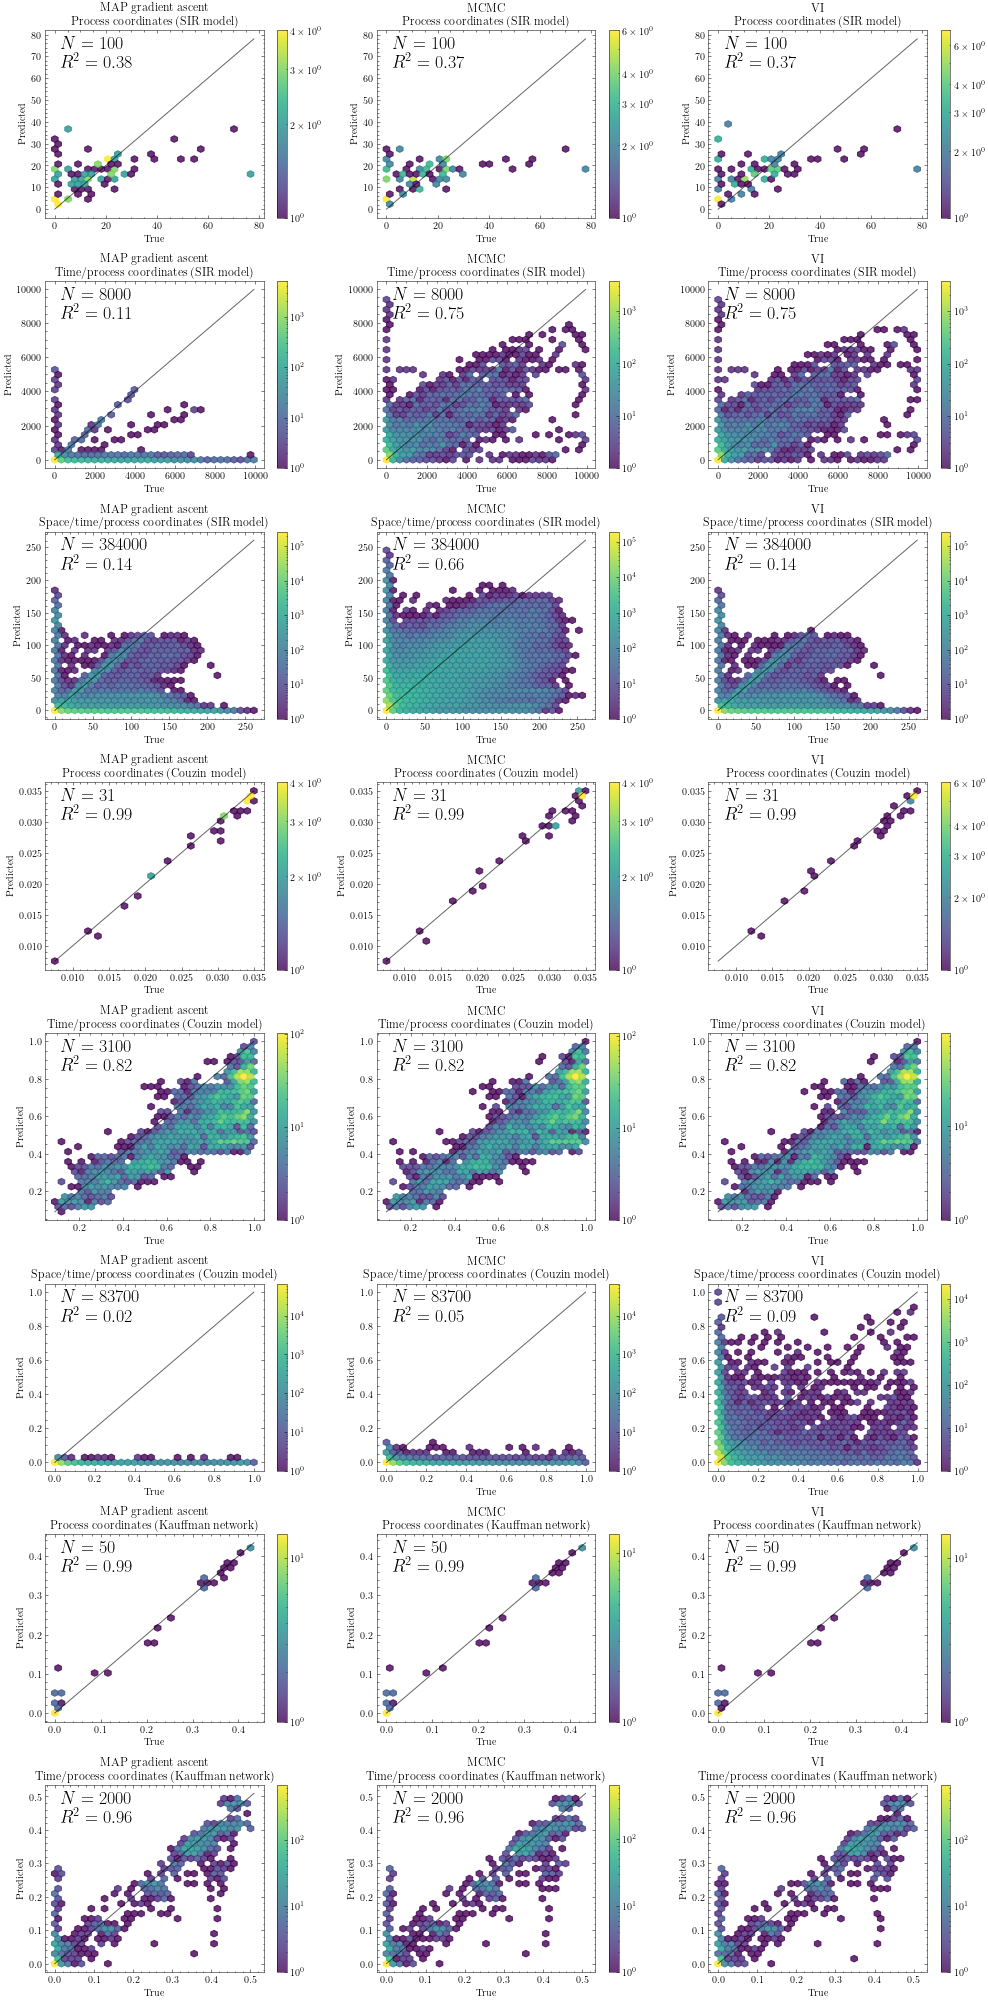

In [11]:
annot_fontsize  = 18
hexbin_alpha    = 0.8
hexbin_gridsize = 30 
save_fig        = True

fig, axes = plt.subplots(8,3, figsize=(14,28))
axes      = axes.ravel()

for i, (token, y_test_std) in enumerate(y_test_dict.items()):
    plt.sca(axes[i])
    dataset, model, alg = token.split('_')
    true, pred = y_test_std.ravel(), samples_mean[token].ravel()
    min_true, max_true = true.min(), true.max()

    plt.hexbin(true, pred, extent=(min_true, max_true, min_true, max_true),
               gridsize=hexbin_gridsize, bins='log', alpha=hexbin_alpha)
    plt.colorbar()
    plt.plot([min_true,max_true],[min_true,max_true],color='k', alpha=0.6)
    r2 = np.corrcoef(true,pred)[1,0]
    axes[i].set_title(FANCY_NAMES[alg]+'\n'+FANCY_NAMES[model] + f' ({FANCY_NAMES[dataset]})')
    axes[i].set_xlabel('True'), axes[i].set_ylabel('Predicted')
    plt.text(0.07,0.80, f'$R^2 = {r2:.2f}$',  transform=axes[i].transAxes, ha='left', fontsize=annot_fontsize)
    plt.text(0.07,0.97, f'$N = {len(true)}$', transform=axes[i].transAxes, ha='left',  fontsize=annot_fontsize, va='top')

plt.tight_layout()

if save_fig:
    plt.savefig('../figures/all_preds.jpg', bbox_inches='tight', dpi=400)

### Plots for time+process predictions with credible intervals

sir_time+process_map 0.10747101526917834 0.6293797008319773
sir_time+process_mcmc 0.7522285109066837 0.6293797008319773
sir_time+process_vi 0.7521443170801835 0.6293797008319773
couzin_time+process_map 0.8198511310823264 0.42093029331774984
couzin_time+process_mcmc 0.8196544374034365 0.42093029331774984
couzin_time+process_vi 0.8198333757414612 0.42093029331774984
kauffman_time+process_map 0.9639841527924663 0.5867607373795027
kauffman_time+process_mcmc 0.9639218133737176 0.5867607373795027
kauffman_time+process_vi 0.9639568650599335 0.5867607373795027


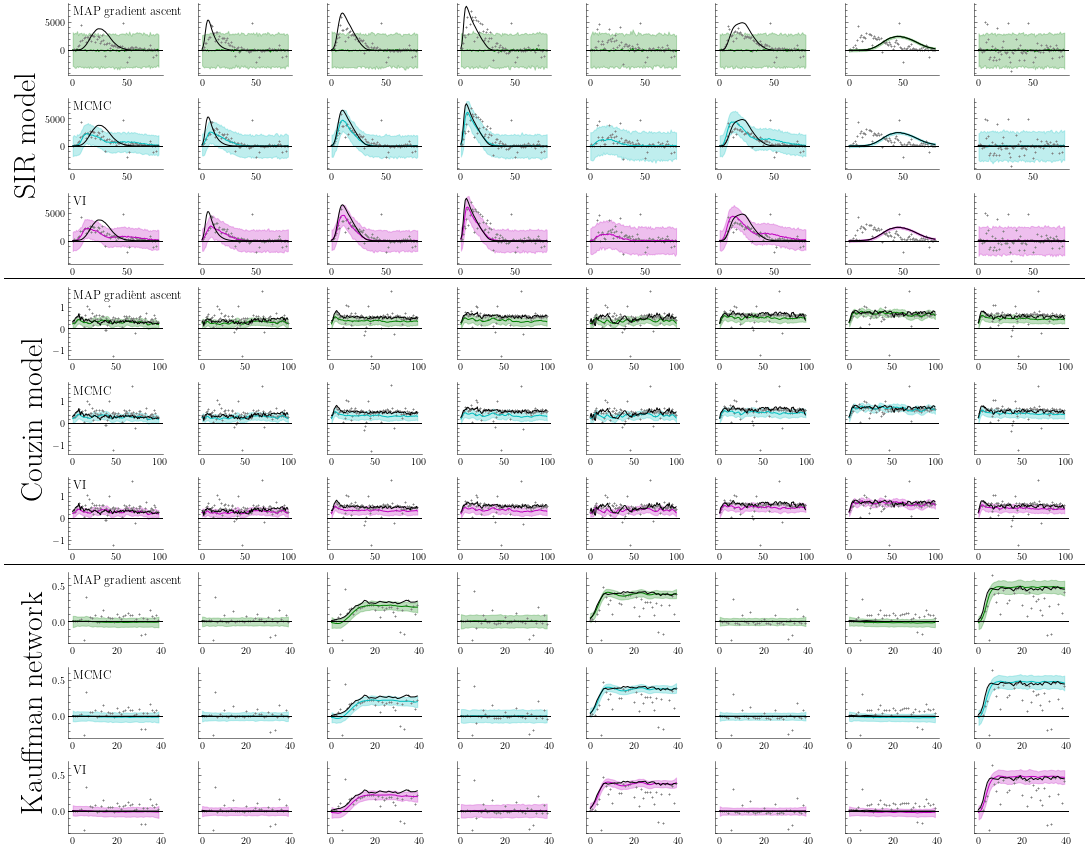

In [12]:
save_figure      = True
ncols            = 8
annotate_xi      = False
hline_on_zero    = True
show_independent = True

nrows = 9

visible_ticks = {
   "top": False,
   "right": False,
   "bottom":False
}

is_interesting_dict = {
    'sir'      : True,
    'couzin'   : False,
    'kauffman' : True
}

fig, axes    = plt.subplots(nrows, ncols, figsize=(15,12), sharey='row')
row_ctr      = 0

rows_for_showing_ylabel = [1, 4, 7]

for k, v in samples_mean.items():
    
    if 'time+process' in k and 'space' not in k:
        dataset, model, alg = k.split('_')
        col_ctr = 0
        i = 0
        
        # We only use MCMC for the IGP benchmark plot
        igp_alg = 'mcmc'
        igp_token = f'{dataset}-{model}-{igp_alg}'
                  
        print(k,
              np.corrcoef(y_test_dict[k].ravel(),v.ravel())[0,1],
              np.corrcoef(y_test_dict[k].ravel(),np.asarray(independent_predictions[igp_token]['mu']).ravel())[0,1])

        
        while col_ctr < ncols:
            if is_interesting_dict[dataset]:
                is_interesting = np.any(samples_qs[k][0,:,i] != 0.)
            else:
                is_interesting = True
            i += 1

            if not is_interesting:
                continue
                
            else:
                plt.sca(axes[row_ctr, col_ctr])
                xs = np.arange(v.shape[0])
                ys = v[:,i]
                plt.plot(ys, color=alg_colors[alg])
                
                ys_true = y_test_dict[k][:, i]
                plt.fill_between(xs, samples_qs[k][0,:,i],  samples_qs[k][1,:,i], alpha=0.25, color=alg_colors[alg])
                plt.plot(ys_true, color='k')
                
                if show_independent:
                    
                    try:
                        mu_pred = np.asarray(independent_predictions[igp_token]['mu'])
                        ys_independent = mu_pred[:, i]
                        plt.scatter(xs, ys_independent, color='0.5', marker='+', s=6)
                    except KeyError:
                        print(f'Skipping independent GP for {igp_token}')
                        
                if hline_on_zero:
                    plt.axhline(0, color='k')

                for spine in ['top','right']:
                    plt.gca().spines[spine].set_visible(False)
                plt.tick_params(which="both", **visible_ticks)
                
                if row_ctr in rows_for_showing_ylabel and col_ctr == 0:
                    plt.ylabel(FANCY_NAMES[dataset], fontsize=30)
                
                if annotate_xi:
                    plt.text(0.9, 0.1, f'$\\xi_{{{i+1}}}$', transform=axes[row_ctr, col_ctr].transAxes, fontsize=24)
                if col_ctr == 0:
                    plt.text( 0.05, 0.95,FANCY_NAMES[alg], 
                             fontsize=12,
                             transform=axes[row_ctr, col_ctr].transAxes,
                             ha='left', va='top', fontweight='bold')

                col_ctr +=1
        row_ctr += 1
plt.tight_layout()

plt.plot([0, 1], [0.33833, 0.33833], color='k', lw=1,transform=fig.transFigure, clip_on=False)
plt.plot([0, 1], [0.66866, 0.66866], color='k', lw=1,transform=fig.transFigure, clip_on=False)

if save_figure:
    figure_filepath = f'../figures/envelopes.jpg'
    plt.savefig(figure_filepath, bbox_inches='tight', dpi=400)

### Comparing explicit vs implicit emulation

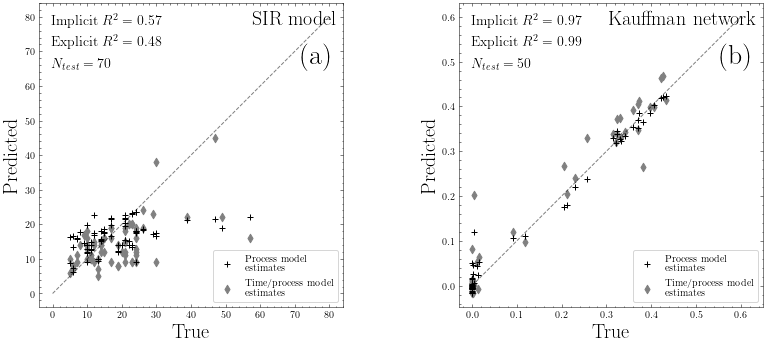

In [13]:
ylims = {
    'sir':[0,80],
    'kauffman':[0,0.6]
}

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes      = axes.ravel()

letters = ['a', 'b']
for i, ds in enumerate():
    token = f'{ds}_process_mcmc'
    token_tp = f'{ds}_time+process_mcmc'
    plt.sca(axes[i])
    xs = y_test_dict[token]
    y1 = samples_mean[token]
    
    if ds in ['sir']:
        is_nontrivial = np.any(y_test_dict[token_tp] > 1000, axis=0)
    else:
        is_nontrivial = np.ones_like(xs, dtype=bool)
    
    if ds == 'sir':
        y2 = np.argmax(samples_mean[token_tp], axis=0)
    elif ds == 'kauffman':
        y2 = samples_mean[token_tp][-1, :]
        
    plt.scatter(xs[is_nontrivial], y1[is_nontrivial], 
                marker='+', color='k', zorder=2, 
                label='Process model\nestimates')
    plt.scatter(xs[is_nontrivial], y2[is_nontrivial], 
                marker='d', color='0.5', 
                label='Time/process model\nestimates')
    plt.legend(loc='lower right', frameon=True)
    corr1 = np.corrcoef(xs[is_nontrivial],y1[is_nontrivial])[1,0]
    corr2 = np.corrcoef(xs[is_nontrivial],y2[is_nontrivial])[1,0]

    plt.text(0.04, 0.93, f"Implicit $R^2={corr2:.2f}$", transform=plt.gca().transAxes,
            fontsize=14)
    plt.text(0.04, 0.86, f"Explicit $R^2={corr1:.2f}$", transform=plt.gca().transAxes,
            fontsize=14)
    plt.text(0.04, 0.79, "$N_{test}="+str(is_nontrivial.sum())+"$", transform=plt.gca().transAxes,
            fontsize=14)
    
    plt.text(0.98, 0.93, FANCY_NAMES[ds], transform=plt.gca().transAxes,
            fontsize=20, ha='right')
    
    plt.text(0.86, 0.80, f"({letters[i]})", transform=plt.gca().transAxes,
            fontsize=28)

    plt.plot(ylims[ds],ylims[ds], linestyle='--', color='k', alpha=0.5)
    plt.axis('square')
    plt.ylabel('Predicted', fontsize=20) 
    plt.xlabel('True', fontsize=20);
    
plt.tight_layout()
plt.savefig('../figures/implicit.png', dpi=400)

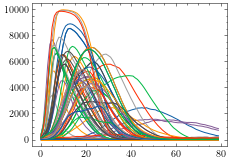

In [14]:
plt.plot(y_test_dict['sir_time+process_mcmc']);

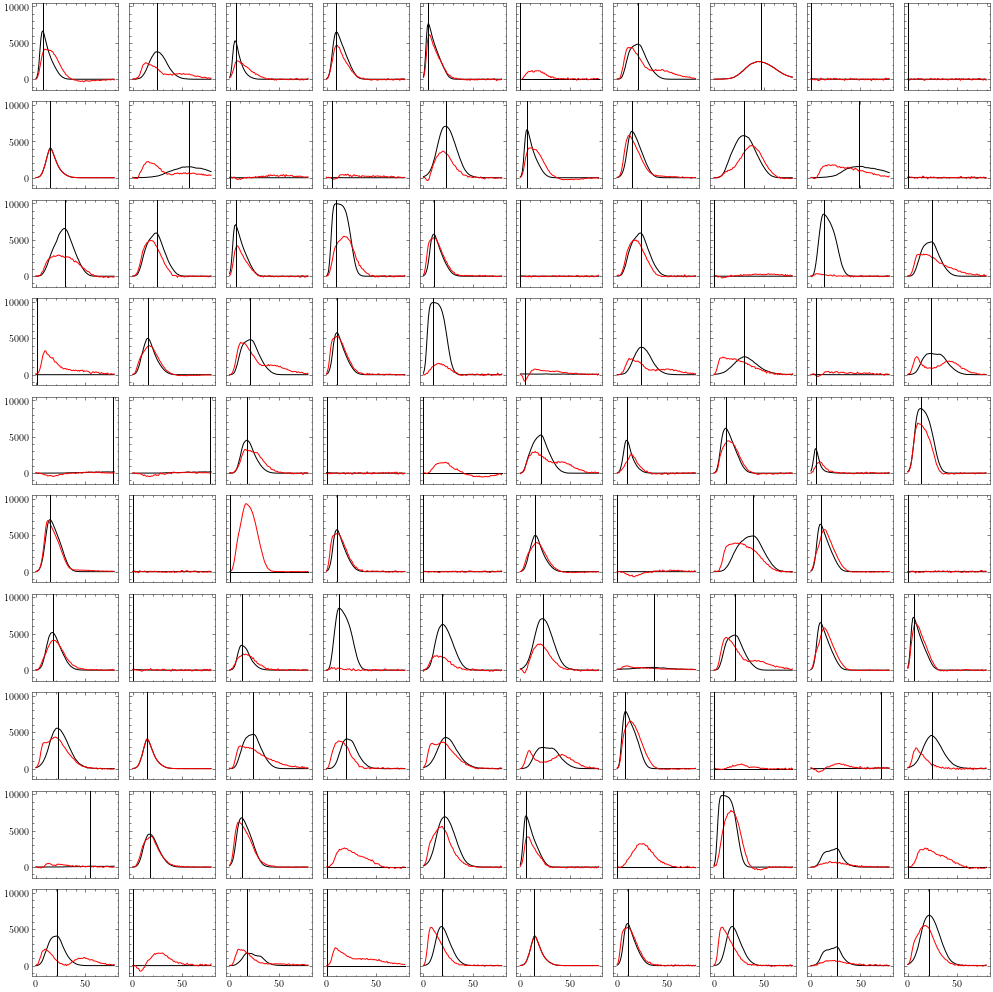

In [15]:
fig, axes = plt.subplots(10,10, figsize=(14,14), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(100):
    axes[i].plot(y_test_dict['sir_time+process_mcmc'][:, i], color='k');
    axes[i].plot(samples_mean['sir_time+process_mcmc'][:, i], color='r');
    axes[i].axvline(y_test_dict['sir_process_mcmc'][i], color='k')
plt.tight_layout()